# Aggregate Productivity Shocks

In [1]:
from time import time

import matplotlib.pyplot as plt

from HARK.ConsumptionSaving.ConsAggShockModel import (
    AggShockConsumerType,
    CobbDouglasEconomy,
    SmallOpenEconomy,
)
from HARK.utilities import plot_funcs, plot_func_slices


def mystr(number):
    return f"{number:.4f}"

Most `AgentType` subclasses in HARK are fully "microeconomic" models in the sense that they concern the decisions of agents under uncertainty, but with no economy-wide interaction among the agents. In particular, objects like the return factor on retained assets are treated as *exogenous*, and we often omit the wage rate entirely (implicitly normalizing it to 1).

The `AgentType` subclasses in `ConsAggShockModel`, in contrast, are designed to be used with subclasses of `Market` and solved in *dynamic stochastic general equilibrium* (DSGE), or more accurately HA-DSGE. For a primer on the `Market` class generally, see the [notebook here](../../Gentle-Intro/Market-Intro.ipynb).

This notebook concerns `AggShockConsumerType`, representing agents in the canonical consumption-saving framework with labor income risk. Unlike other `AgentType` subclasses that face only idiosyncratic income shocks, `AggShockConsumerType`s are *also* subject to aggregate productivity shocks, both permanent and transitory. Moreover, these agents can be embedded in a `CobbDouglasEconomy` in which the interest and wage factors are determined endogenously based on the ratio of aggregate labor and capital.

## Microeconomic Model Statement for `AggShockConsumerType`

`AggShockConsumerType` extends `IndShockConsumerType` by incorporating a second continuous state variable (aggregate market resources $M_t$) as well as two additional shocks: permanent $\Psi$ and transitory $\Theta$ shocks to aggregate productivity. Because some objects are idiosyncratic (varying across individuals) and others are aggregate, we explicitly include the $i$ subscript to indicate idiosyncratic values.

\begin{eqnarray*}
\text{v}(m_{it}, M_t) &=& \max_{c_{it}} \frac{c_{it}^{1-\rho}}{1-\rho} + \beta \mathsf{S} \mathbb{E} \left[ (\psi_{it+1} \Psi_{t+1})^{1-\rho} \text{v}(m_{it+1}, M_{t+1}) \right] \\
&\text{s.t.}& \\
a_{it} &=& m_{it} - c_{it} \geq \underline{a}, \\
A_{t} &=& \mathbf{A}(M_{it}), \\
K_{t+1} &=& A_t, \\
k_{t+1} &=& K_t / \Psi_{t+1}, \\
\mathsf{R}_{t+1} &=& \mathbf{R}(k_{t+1} / \Theta_{t+1}), \\
\mathsf{w}_{t+1} &=& \mathbf{W}(k_{t+1} / \Theta_{t+1}), \\
m_{it+1} &=& \mathsf{R}_{t+1} a_{t} / (\psi_{it+1} \Psi_{t+1}) + \mathsf{w}_{t+1} \theta_{it+1} \Theta_{t+1}, \\
M_{t+1} &=& \mathsf{R}_{t+1} k_{t+1} + \mathsf{w}_{t+1} \Theta_{t+1}, \\
(\psi_{it+1}, \theta_{it+1}) &\sim& F, \\
(\Psi_{t+1}, \theta_{t+1}) &\sim& \Phi.
\end{eqnarray*}

Much of this model is identical to the workhorse `IndShockConsumerType` model, but with substantial additions and changes. Capitalized and serifed variables represent aggregate normalized variables; e.g. $M_t$ is aggregate market resources normalized by aggregate permanent productivity.

Aggregate capital next period $K_{t+1}$ is simply aggregate retained assets $A_t$. The aggregate productivity shocks $(\Psi, \Theta)$ are assumed to affect effective labor, which is inelastically supplied. The ratio of aggregate capital to aggregate *permanent* labor productivity is thus denoted as $k_t$.

The interest $\mathsf{R}$ and wage $\mathsf{w}$ factors are determined as functions of the aggregate capital-to-labor ratio (incorporating the transitory aggregate shock as well). At both the individual and aggregate level, next period's market resources are the sum of capital and labor income.

We denote the aggregate productivity shock distribution as $\Phi$, which does *not* stand for the standard normal distribution.

## Model Statement for a `CobbDouglasEconomy` 

A careful reader will notice that we have not specified *how* the aggregate capital-to-labor ratio determines the interest factor and wage rate. Moreover, we also did not mention the aggregate savings function $\mathbf{A}(M_t)$ at all. This was intentional, because there are (at least) two possibilities. An `AggShockConsumerType` instance can't be meaningfully solved outside of some `Market` that it lives in, and how aggregate capital and labor determine factor prices is an activity at the `Market`-level.

An instance of `CobbDouglasEconomy`, a subclass of `Market` represents an economy in which capital and labor are used to produce output with a Cobb-Douglas technology, and factor prices are determined competitively via the marginal product of each factor. We denote capital's share of production `CapShare` as $\alpha$ and the depreciation rate of capital `DeprRte` as $\delta$.

The interest factor and wage rate can thus be determined from aggregate capital and labor as follows:

\begin{eqnarray*}
Y &=& K^\alpha L^{1-\alpha}, \\
\mathsf{w} &=& \frac{\partial Y}{\partial L} = (1-\alpha) K^\alpha L^{-\alpha} = (1-\alpha) k^{\alpha}, \\
\mathsf{r} &=& \frac{\partial Y}{\partial K} = \alpha K_{t}^{\alpha-1} L_t^{1-\alpha} = \alpha k^{1-\alpha}, \\
\mathsf{R} &=& 1 - \delta + \mathsf{r}.
\end{eqnarray*}

In the last line, the return factor on capital represents the individual retaining their capital, less depreciation, and being paid the gross interest rate $\mathsf{r}$ for it. These expressions are used as the functional forms for $\mathbf{R}$ and $\mathbf{W}$ above.

Following Krusell \& Smith (1998), we parameterize the aggregate saving function $\mathbf{A}(M_{it})$ as linear in logs:

\begin{equation*}
A_{it} = \mathbf{A}(M_{it}) = \exp(\kappa_1 \log(M_{it}) + \kappa_0).
\end{equation*}

This function represents the agents' *parameterized beliefs* about aggregate behavior, rather than true dynamics. It is used by agents when *solving* their microeconomic model to form expectations about future resources (through factor prices), representing a form of bounded rationality: future factor prices depend on *all consumers'* financial position, but the agents only account for the aggregate quantity when making their projection, and then only with a parametric relationship.

The microeconomic model can be solved for *any* such subjective beliefs, but the goal of solving the model in general equilibrium is to find beliefs that are *consistent*: if agents' act optimally given those beliefs about aggregate saving, then the relationship between $M_{t}$ and $A_{t}$ that emerges in the long run is *well approximated by* those same beliefs.

In the terminology of HARK's `Market` class, the only element of `dyn_vars` is `AFunc`, the aggregate saving function, which is characterized by the two coefficients $\kappa_0$ and $\kappa_1$. When a `CobbDouglasEconomy` instance has its `solve` method invoked, it executes the following in a loop:

0) Begin with arbitrary initial $\kappa_0$ and $\kappa_1$
1) Agents solve their microeconomic model given beliefs
2) Simulate market for many periods, generating history of $(M_t, A_t)$
3) Linearly regress $\log A_t$ on $\log M_t$ to generate new $\kappa_0$ and $\kappa_1$
4) If new coefficients are not sufficiently close to old ones, go to step 1

During the simulation, the agents observe the true $M_t$ in each period. Their subjective beliefs are used only when *solving* the model, not when simulating it.

## Keeping it Simple: `SmallOpenEconomy`

As an alternative to `CobbDouglasEconomy`, you might instead be interested in an environment in which factor prices do *not* fluctuate with aggregate capital and labor (say, because capital is mobile and thus prices are determined by global factors), but there are still aggregate productivity shocks. HARK handles this with the `SmallOpenEconomy` subclass of `Market`.

The mechanics of a `SmallOpenEconomy` are simple: the user provides a *fixed* `Rfree` and `wRte` (as well as the `AggShkDstn`) and the functions $\mathbf{R}(\cdot)$ and $\mathbf{W}(\cdot)$ are specified as `ConstantFunctions` with those values. The aggregate saving function $\mathsf{A}(M_t)$ is *irrelevant* because the agents know that their future state does not depend on the aggregate state at all; it's arbitrarily specified as the identity function. With a `SmallOpenEconomy`, the agents' microeconomic problem thus only needs to be solved *once*, rather than iterated on to find equilibrium beliefs about aggregate saving.

Put differently, the *structure* of the microeconomic problem is identical whether `CobbDouglasEconomy` or `SmallOpenEconomy` is used, but some details are simplified and trivialized under the latter.

## Example implementations of `AggShockConsumerType`

In [2]:
# Make an aggregate shocks consumer type
AggShockExample = AggShockConsumerType(cycles=0)
AggShockExampleAlt = AggShockConsumerType(cycles=0, MaggCount=3)

# Make a Cobb-Douglas economy for the agents
CobbDouglasExample = CobbDouglasEconomy(agents=[AggShockExample])
CobbDouglasExample.make_AggShkHist()  # Simulate a history of aggregate shocks
CobbDouglasExample.give_agent_params()  # Have agents collect market-level parameters and construct themselves

# Make a small open economy for the agents
SOEexample = SmallOpenEconomy(agents=[AggShockExampleAlt])
SOEexample.make_AggShkHist()  # Simulate a history of aggregate shocks
SOEexample.give_agent_params()  # Have agents collect market-level parameters and construct themselves

In [3]:
# Solve the small open economy with the default parameters
t_start = time()
SOEexample.solve()
t_end = time()
print(
    "Solving a small open economy took " + mystr(t_end - t_start) + " seconds.",
)

Solving a small open economy took 9.7542 seconds.


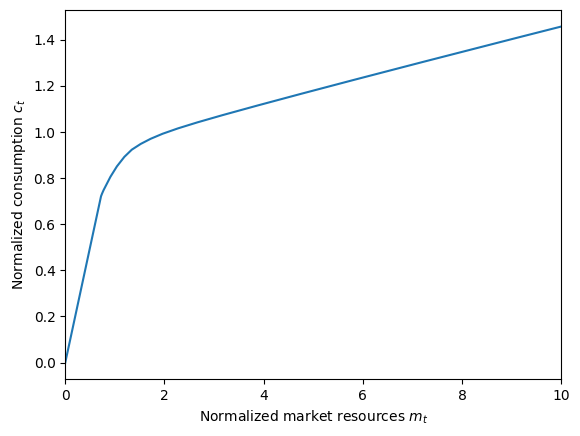

In [4]:
AggShockExampleAlt.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_func_slices(AggShockExampleAlt.cFunc[0], 0.0, 10.0, Z=[1.0])
plt.show()

In [5]:
# Solve the "macroeconomic" model by searching for a "fixed point dynamic rule"
t_start = time()
print(
    "Now solving for the equilibrium of a Cobb-Douglas economy. This might take a few minutes...",
)
CobbDouglasExample.solve()
t_end = time()
print(
    'Solving the "macroeconomic" aggregate shocks model took '
    + mystr(t_end - t_start)
    + " seconds.",
)

Now solving for the equilibrium of a Cobb-Douglas economy. This might take a few minutes...
intercept=-0.34225704690379455, slope=1.1036802534896566, r-sq=0.9966235168150562
intercept=-0.5048662684011551, slope=1.1521207801269897, r-sq=0.9967296231268286
intercept=-0.44009055091285676, slope=1.1073003762357754, r-sq=0.9796571592307225
intercept=-0.3727583496748521, slope=1.0800958134599425, r-sq=0.9888403549938374
intercept=-0.3507131461697174, slope=1.0714775734787123, r-sq=0.9913861032824601
intercept=-0.3412811495116656, slope=1.0678299783323966, r-sq=0.9917042799357173
intercept=-0.3371997345196811, slope=1.0662638842288006, r-sq=0.9918210930314515
intercept=-0.33543678369689256, slope=1.065591530676302, r-sq=0.9918686991220076
intercept=-0.33467883202472837, slope=1.06530389082849, r-sq=0.9918887018640774
intercept=-0.3343546337095779, slope=1.0651813619488595, r-sq=0.9918971767796609
intercept=-0.3342166296959199, slope=1.0651293833970874, r-sq=0.9919007696687092
intercept=-0.334

Aggregate savings as a function of aggregate market resources:


C:\Users\Matthew\Documents\GitHub\HARK\HARK\ConsumptionSaving\ConsAggShockModel.py:3024: RuntimeWarning: divide by zero encountered in log
  Aagg = np.exp(self.intercept + self.slope * np.log(Mnow))


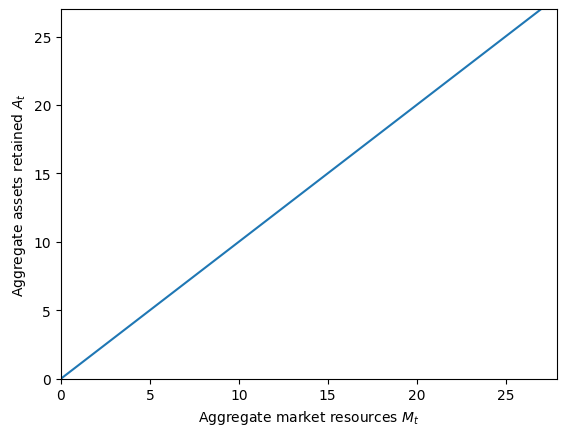

In [8]:
print("Aggregate savings as a function of aggregate market resources:")
plt.xlabel(r"Aggregate market resources $M_t$")
plt.ylabel(r"Aggregate assets retained $A_t$")
plt.ylim(0.0, 27.0)
plot_funcs(CobbDouglasExample.AFunc, 0, 2 * CobbDouglasExample.kSS)

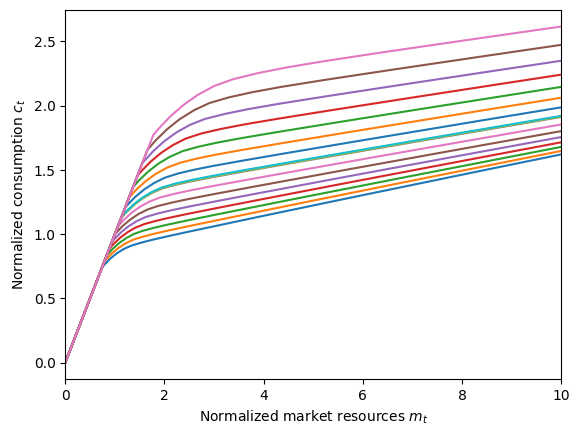

In [10]:
AggShockExample.unpack("cFunc")
plt.xlabel(r"Normalized market resources $m_t$")
plt.ylabel(r"Normalized consumption $c_t$")
plot_func_slices(AggShockExample.cFunc[0], 0.0, 10.0, Z=AggShockExample.Mgrid)